In [ ]:
# Listing 6.1 Reprising Airbnb NYC dataset

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data = pd.read_csv("https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/AB_NYC_2019.csv")
excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id', 
                  'last_review', 'name', 'host_name'] #A
low_card_categorical = ['neighbourhood_group', 'room_type'] #B
high_card_categorical = ['neighbourhood'] #C
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
              'calculated_host_listings_count', 'availability_365'] #D
target_mean = (data["price"] > data["price"].mean()).astype(int) #E
target_median = (data["price"] > data["price"].median()).astype(int) #F
target_multiclass = pd.qcut(data["price"], q=5, labels=False) #G
target_regression = data["price"] #H
categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore')
categorical_ord_encoding = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
numeric_standardization = Pipeline([('StandardScaler', StandardScaler()), 
                                    ('Imputer', SimpleImputer(strategy="constant", fill_value=0))])

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', categorical_ord_encoding, high_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0) #I

lm_column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0) #J

#A list of excluded columns for feature processing
#B list of categorical columns with low cardinality to be one-hot encoded
#C list of categorical column with high cardinality to be ordinally encoded
#D list of continuous feature columns
#E creating a binary target indicating whether the price is above the mean (unbalanced binary target)
#F creating a binary target indicating whether the price is above the median (balanced binary target)
#G creating a multiclass target by quantile binning the price into 5 classes
#H setting the target for regression as the price column
#I creating a column transformer that applies different transformations to different groups of features
#J creating a column transformer suitable for linear models

In [ ]:
# Listing 6.2 Multivariate imputation

from sklearn.experimental import enable_iterative_imputer #A
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

Xm = data[continuous].copy() #B
missing_percentage = 0.05
np.random.seed(0)
mask = np.random.rand(*Xm.shape) < missing_percentage #C
Xm[mask] = np.nan

simple_imputer = SimpleImputer()
Xm_si = simple_imputer.fit_transform(Xm) #D

rf = RandomForestRegressor(random_state=0, n_jobs=-1) #E
multivariate_imputer = IterativeImputer(estimator=rf, max_iter=1, tol=0.01) #F
Xm_mi = multivariate_imputer.fit_transform(Xm) #G

mae = pd.DataFrame({"simple": np.mean(np.abs(data[continuous] - Xm_si), axis=0),
                 	"multivariate": np.mean(np.abs(data[continuous] - Xm_mi), axis=0)},
                	index = continuous) #H
print(mae)

#A importing IterativeImputer which is still experimental and under improvement in Scikit-learn
#B creating a copy of continuous feature data
#C creating a mask to randomly mark missing values
#D using a SimpleImputer instance with mean imputation strategy
#E instantiating a RandomForestRegressor for iterative imputation
#F creating an IterativeImputer instance with max_iter and tol are the stopping criteria
#G imputing missing data using iterative imputation
#H calculating Mean Absolute Error (MAE) for imputed data and original data

                                  simple  multivariate
minimum_nights                  0.347355      0.260156
number_of_reviews               1.327776      0.858506
reviews_per_month               0.057980      0.036876
calculated_host_listings_count  0.579423      0.368567
availability_365                6.025748      4.622640


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Listing 6.3 Creating a high cardinality categorical feature

def bin_2_cat(feature, bins=100):
    min_value = feature.min()
    bin_size = (feature.max() - min_value) / bins
    return ((feature - min_value) / bin_size).astype(int) # A
    
data['coordinates'] = bin_2_cat(data['latitude']) * 1000 + bin_2_cat(data['longitude']) #B
high_card_categorical += ['coordinates']

print(data[high_card_categorical].nunique()) #C

#A function to convert numerical data into categorical bins
#B converting latitude and longitude to categorical coordinates 
#C printing the number of unique values in the high-cardinality categorical features

neighbourhood     221
coordinates      2259
dtype: int64


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Listing 6.4 Using target encoding in the pipeline

from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, make_scorer

target_encoder = TargetEncoder(cols=high_card_categorical, # A
                               smoothing=0.5) # B
accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3) #C

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', target_encoder, high_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0) #D

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('model', xgb)]) #E

cv_scores = cross_validate(estimator=model_pipeline,
                       	X=data,
                       	y=target_median,
                       	scoring=accuracy,
                       	cv=cv,
                       	return_train_score=True,
                       	return_estimator=True) #F

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #G

#A initializing TargetEncoder for high-cardinality categorical features
#B smoothing value to blend prior and posterior probabilities
#C initializing XGBoost Classifier with specific hyperparameters
#D defining ColumnTransformer for preprocessing features with TargetEncoder for high-cardinality categorical features
#E creating a pipeline that combines preprocessing and modeling
#Fperforming five-fold cross-validation and obtaining evaluation metrics
#G printing mean accuracy, fit time, and prediction time from cross-validation

0.840 (0.003) fit: 11.87 secs pred: 0.08 secs


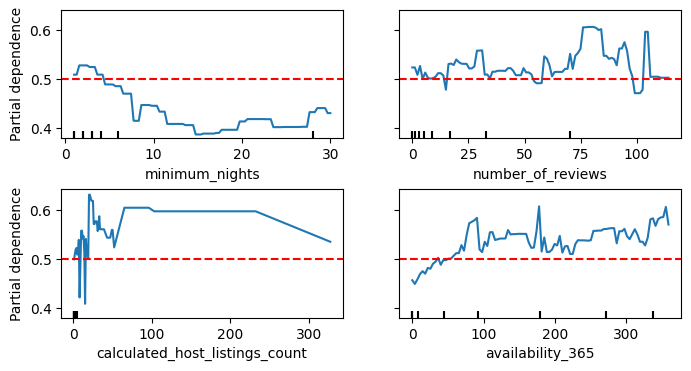

In [ ]:
# Listing 6.5 Partial Dependence Plot

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

xgb = XGBClassifier(booster='gbtree', 
                    objective='reg:logistic', 
                    n_estimators=300, 
                    max_depth=4,
                    min_child_weight=3)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('xgboost', xgb)]) #A

model_pipeline.fit(X=data, y=target_median)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4)) #B
fig.subplots_adjust(hspace=0.4, wspace=0.2) 

PartialDependenceDisplay.from_estimator(model_pipeline, 
                                        X=data, 
                                        kind='average', #C
                                        features=['minimum_nights', 
                                                  'number_of_reviews', 
                                                  'calculated_host_listings_count', 
                                                  'availability_365'], #D
                                       ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--') #E
    
plt.show()

#A creating a model pipeline combining data processing and XGBoost classifier
#B creating a 2x2 subplot layout
#C creating a partial dependence plot of average effect
#D a list specifying features for the plot
#E adding a red dashed line at y=0.5 on each subplot, a reference line for interpretation

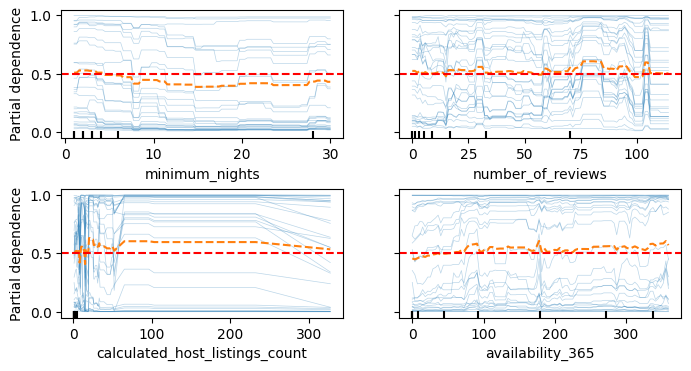

In [ ]:
# Listing 6.6 ICE plots

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

PartialDependenceDisplay.from_estimator(model_pipeline, 
                                        X=data, 
                                        kind='both', #A
                                        subsample=30, #B
                                        features=['minimum_nights', 
                                                  'number_of_reviews', 
                                                  'calculated_host_listings_count', 
                                                  'availability_365'],
                                       ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--')
    ax.legend().set_visible(False)

plt.show()

#A creating a partial dependence plot showing both individual (PDP) and average effects (ICE)
#B using a random subset of 30% of data for plotting efficiency

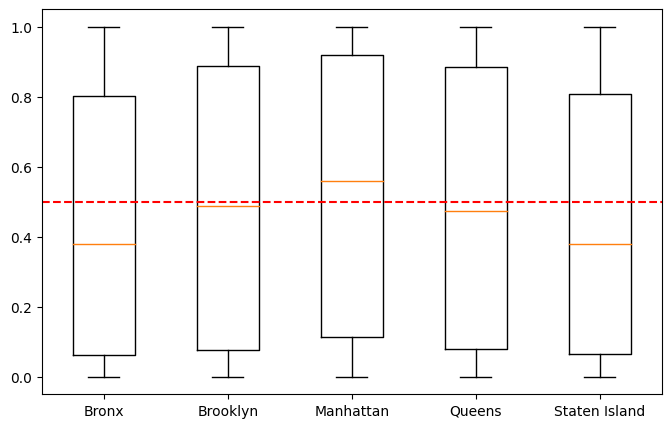

In [ ]:
# Listing 6.7 Partial Dependence Plot for binary features

from sklearn.inspection import partial_dependence #A
import matplotlib.pyplot as plt

pd_ice = partial_dependence(model_pipeline, X=data, 
                            features=['neighbourhood_group'], 
                            kind='both')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
labels = np.ravel(pd_ice['values'])
plt.boxplot(pd_ice["individual"].squeeze(), labels=labels) #B
ax.axhline(y=0.5, color='red', linestyle='--') #C
plt.show()

#A importing the partial_dependence function that computes the curves values
#B creating a box plot of individual ICE curves
#C adding a red dashed line at y=0.5 on each subplot, a reference line for interpretation

In [ ]:
!pip install xgbfir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.9 MB/s eta 0:00:00


high_card_categories__coordinates|low_card_categories__room_type_Entire home/apt
high_card_categories__neighbourhood|low_card_categories__room_type_Entire home/apt
high_card_categories__coordinates|high_card_categories__coordinates
high_card_categories__coordinates|high_card_categories__neighbourhood
high_card_categories__neighbourhood|numeric__availability_365
high_card_categories__coordinates|numeric__availability_365
high_card_categories__coordinates|numeric__minimum_nights
high_card_categories__neighbourhood|numeric__minimum_nights
high_card_categories__coordinates|numeric__calculated_host_listings_count
high_card_categories__coordinates|numeric__reviews_per_month


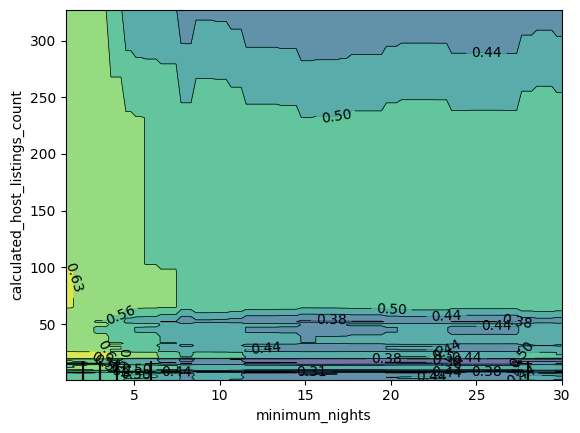

In [ ]:
# Listing 6.8 Discovering interactions by XGBFIR

import xgbfir
xgbfir.saveXgbFI(model_pipeline['xgboost'], 
                 feature_names=model_pipeline['processing'].get_feature_names_out(), 
                 OutputXlsxFile='fir.xlsx') #A
fir = pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1') #B
result = fir[["Interaction", "Gain"]].sort_values(by="Gain",               
                                            ascending=False).head(10).round(2) #C
for index, row in result.iterrows():
    print(f"{row['Interaction']}")

PartialDependenceDisplay.from_estimator(model_pipeline, 
                                        X=data, 
                                        kind='average',
                                        features=[('minimum_nights', 
                                                  'calculated_host_listings_count')]) #D

#A generating a report with xgbfir and saving it to an Excel file
#B reading the Excel file created in the previous steps
#C extracting and sorting based on split gain the "Interaction" and "Gain" columns from the feature interaction report
#D generating a partial dependence plot for the features "minimum_nights" and "calculated_host_listings_count"

In [ ]:
# Listing 6.9 Stability Selection

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
 
lambda_grid=np.logspace(-4, -1, 10) #A
sparse_coef = list()

for modeling_c in lambda_grid:
    estimator = LogisticRegression(solver='liblinear', penalty='l1', C=modeling_c) #B
    model = BaggingClassifier(estimator, n_estimators=100, bootstrap=True) #C
    model_pipeline = Pipeline(
        [('processing', lm_column_transform),
         ('standardize', StandardScaler()), #D
         ('modeling', model)])
    model_pipeline.fit(data, target_median)
    sparse_coef += [estimator.coef_.ravel() for estimator in model_pipeline["modeling"].estimators_]
    
epsilon = 1e-2 #E
threshold = 0.5 #F

non_zero = (np.abs(sparse_coef) > epsilon).mean(axis=0)
feature_names = model_pipeline["processing"].get_feature_names_out()
print(non_zero)
print(feature_names[non_zero > threshold])

#A generating a grid of lambda values using a logarithmic scale for use in L1 regularization
#B creating a Logistic Regression estimator with L1 (Lasso) penalty
#C creating a BaggingClassifier that uses the Logistic Regression estimator as its base model
#D standardizing after data processing renders all the coefficients comparable, no matter the scale
#E setting a small value as epsilon for a threshold
#F setting a threshold value for selecting significant coefficients

[0.629 0.    0.9   0.7   0.598 1.    0.    0.599 0.585 0.583 0.445 0.51
 0.7  ]
['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__neighbourhood_group_Manhattan'
 'low_card_categories__neighbourhood_group_Queens'
 'low_card_categories__neighbourhood_group_Staten Island'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Shared room' 'numeric__minimum_nights'
 'numeric__number_of_reviews' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
! pip install Boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Listing 6.10 Boruta selection

from xgboost import XGBClassifier
from boruta import BorutaPy

xgb = XGBClassifier(booster='gbtree', 
                    objective='reg:logistic', 
                    n_estimators=300, 
                    max_depth=4,
                    min_child_weight=3)

X = column_transform.fit_transform(data, target_median) #A
boruta_selector = BorutaPy(estimator=xgb, n_estimators='auto', verbose=2) #B
boruta_selector.fit(X, target_median) #C
selected_features = boruta_selector.support_ #D
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A transforming the input data, performing any necessary preprocessing steps
#B initializing a BorutaPy feature selection object using a XGBoost classifier
#C fitting the Boruta feature selector
#D retrieving a Boolean mask of selected features determined by the Boruta feature selector

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
I

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type='gbdt', 
                      n_estimators=300, 
                      max_depth=4,
                      min_child_samples=3)

boruta_selector = BorutaPy(estimator=lgbm, n_estimators='auto', verbose=2) #A
boruta_selector.fit(X, target_median)
selected_features = boruta_selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A initializing a BorutaPy feature selection object using the provided LightGBM classifier

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	7
['low_card_categories__room_type_Entire home/apt'
 'high_card_categories__neighbourhood' 'high_card_categories__coordinates'
 'numeric__minimum_nights' 'numeric__number_of_reviews'
 'numeric__reviews_per_month' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
# Listing 6.11 Forward selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree', 
                    objective='reg:logistic', 
                    n_estimators=300, 
                    max_depth=4,
                    min_child_weight=3)

cv = KFold(5, shuffle=True, random_state=0) #A
accuracy = make_scorer(accuracy_score) #B
X = column_transform.fit_transform(data, target_median)
selector = SequentialFeatureSelector(estimator=xgb,
                                     n_features_to_select="auto",
                                     tol=0.0001, #C
                                     direction="forward", #D
                                     scoring=accuracy,
                                     cv=cv)
selector.fit(X, target_median)
selected_features = selector.support_ #E
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A initializing a KFold cross-validation splitter object with five folds
#B creating a scoring function for use in the feature selection process
#C setting a tolerance value used by the sequential feature selector to determine convergence during the search
#D specifying the direction of feature selection (which is "forward" in this case)
#E retrieving a Boolean mask of selected features

['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Shared room'
 'high_card_categories__neighbourhood' 'high_card_categories__coordinates'
 'numeric__minimum_nights' 'numeric__number_of_reviews'
 'numeric__reviews_per_month' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
selector = SequentialFeatureSelector(estimator=xgb,
                                     n_features_to_select="auto",
                                     tol=0.0001,
                                     direction="backward", #A
                                     scoring=accuracy,
                                     cv=cv)
selector.fit(X, target_median)
selected_features = selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A specifying the direction of feature selection (which is "backward" in this case)

['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__neighbourhood_group_Brooklyn'
 'low_card_categories__neighbourhood_group_Manhattan'
 'low_card_categories__neighbourhood_group_Queens'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Private room'
 'low_card_categories__room_type_Shared room'
 'high_card_categories__neighbourhood' 'high_card_categories__coordinates'
 'numeric__minimum_nights' 'numeric__number_of_reviews'
 'numeric__reviews_per_month' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
# Listing 6.12 Grid search

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = LogisticRegression(solver="saga", max_iter=5_000)

model_pipeline = Pipeline(
    [('processing', lm_column_transform),
     ('model', model)])

search_grid = [
    {"model__penalty": [None]},
    {"model__penalty": ["l1", "l2"], "model__C": np.logspace(-4, 4, 10)},
    {"model__penalty": ["elasticnet"], "model__C": np.logspace(-4, 4, 10), 
     "model__l1_ratio": [.1, .3, .5, .7, .9, .95, .99]},
] #A

search_func = GridSearchCV(estimator=model_pipeline, #B
                           param_grid=search_grid, 
                           scoring=accuracy, 
                           n_jobs=-1, 
                           cv=cv)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_) #C
print (search_func.best_score_) #D

#A a list of dictionaries specifying a search grid of hyperparameters for the logistic regression model
#B initializing a GridSearchCV object using the defined search grid
#C printing the best hyperparameters found by the grid search
#D printing the best score achieved by the model using the best hyperparameters found during the grid search

{'model__penalty': None}
0.8210860006135597


In [ ]:
# Listing 6.13 Random search

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)

xgb = XGBClassifier(booster='gbtree', objective='reg:logistic')
model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)]) #A

search_dict = { #B
    'xgb__n_estimators': np.arange(100, 2000, 100), 
    'xgb__learning_rate': loguniform(0.01, 1),
    'xgb__max_depth': np.arange(1, 8),
    'xgb__subsample': np.arange(0.1, 0.9, 0.05),
    'xgb__colsample_bytree': np.arange(0.1, 0.9, 0.05),
    'xgb__reg_lambda': loguniform(1e-9, 100),
    'xgb__reg_alpha': loguniform(1e-9, 100)
}

search_func = RandomizedSearchCV(estimator=model_pipeline, 
                                 param_distributions=search_dict, 
                                 n_iter=60, #C
                                 scoring=accuracy, 
                                 n_jobs=1, #D
                                 cv=cv, 
                                 random_state=0)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_) #E
print (search_func.best_score_) #F

#A creating a pipeline that combines data processing and the XGBoost classifier
#B a dictionary containing various hyperparameters with their search spaces for the RandomizedSearchCV
#C specifying the number of iterations for the random search process
#D specifyingthe number of parallel jobs to run for the search
#E printing the best hyperparameters found by the RandomizedSearchCV
#F printing the best score achieved using the best hyperparameters found during the random search

{'xgb__colsample_bytree': 0.7500000000000002, 'xgb__learning_rate': 0.02785392800820962, 'xgb__max_depth': 6, 'xgb__n_estimators': 1300, 'xgb__reg_alpha': 0.0018420816669457972, 'xgb__reg_lambda': 9.401548382548757e-05, 'xgb__subsample': 0.8500000000000002}
0.8420901932712956


In [ ]:
# Listing 6.14 Halving random search

from sklearn.experimental import enable_halving_search_cv #A
from sklearn.model_selection import HalvingRandomSearchCV

search_func = HalvingRandomSearchCV(estimator=model_pipeline,
                                    param_distributions=search_dict,
                                    resource='n_samples',#B
                                    n_candidates=20,#C
                                    factor=3,#D
                                    min_resources=int(len(data) * 0.3), #E
                                    max_resources=len(data), #F
                                    scoring=accuracy,
                                    n_jobs=1,
                                    cv=cv,
                                    random_state=0)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_)
print (search_func.best_score_)

#A enabling the experimental HalvingRandomSearchCV module
#B specifying that the resource being used for halving is the number of samples
#C setting the number of candidates that will be sampled and evaluated at the first iteration
#D determiningthe factor by which the number of candidates will be reduced in each iteration
#E setting the minimum number of resources (samples) that will be used in the halving process
#E setting the maximum number of resources (samples) that will be used in the halving process

{'xgb__colsample_bytree': 0.6500000000000001, 'xgb__learning_rate': 0.02714215181104359, 'xgb__max_depth': 7, 'xgb__n_estimators': 400, 'xgb__reg_alpha': 3.281921389446602, 'xgb__reg_lambda': 0.00039687940902191534, 'xgb__subsample': 0.8000000000000002}
0.842090909090909


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Listing 6.15 Bayesian search with Optuna

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    } #A
    
    xgb = XGBClassifier(booster='gbtree', objective='reg:logistic', **params) #B
    model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])
    accuracy = make_scorer(accuracy_score)
    cv = KFold(5, shuffle=True, random_state=0)

    cv_scores = cross_validate(estimator=model_pipeline, 
                               X=data, 
                               y=target_median,
                               scoring=accuracy,
                               cv=cv) #C

    cv_accuracy = np.mean(cv_scores['test_score'])
    return cv_accuracy #D

study = optuna.create_study(direction="maximize") #E
study.optimize(objective, n_trials=60) #F
print(study.best_value) #G
print(study.best_params) #H

#A a dictionary defining the search space for hyperparameters for Optuna
#B creating an XGBoost classifier with hyperparameters suggested by Optuna
#C performing cross-validation to evaluate the model's performance using the hyperparameters
#D a function acting as the objective value for optimization by returning the mean accuracy score from cross-validation 
#E creating an Optuna study object with the goal of maximizing the objective function
#F starting the optimization process using the defined objective function and a maximum of 60 trials
#G printing the best achieved value of the objective function
#H printing the best hyperparameters found by Optuna

[I 2023-07-10 18:18:30,612] A new study created in memory with name: no-name-6a6d6451-64a5-49d3-a45f-8b15281db425
[I 2023-07-10 18:19:33,188] Trial 0 finished with value: 0.8331322221086002 and parameters: {'n_estimators': 390, 'learning_rate': 0.02095261094064857, 'subsample': 0.6388917104123202, 'colsample_bytree': 0.1971269783391656, 'max_depth': 5, 'min_child_weight': 2, 'reg_lambda': 2.2118252417060055e-06, 'reg_alpha': 0.43624535602948883}. Best is trial 0 with value: 0.8331322221086002.
[I 2023-07-10 18:19:46,762] Trial 1 finished with value: 0.7813886900501074 and parameters: {'n_estimators': 120, 'learning_rate': 0.8918047726259767, 'subsample': 0.15286216060832633, 'colsample_bytree': 0.33980642623349566, 'max_depth': 6, 'min_child_weight': 2, 'reg_lambda': 0.013037945425269986, 'reg_alpha': 3.18113993173911e-07}. Best is trial 0 with value: 0.8331322221086002.
[I 2023-07-10 18:21:08,821] Trial 2 finished with value: 0.8348501891808979 and parameters: {'n_estimators': 1827, '

0.8426628489620617
{'n_estimators': 1229, 'learning_rate': 0.01698350502174693, 'subsample': 0.9728026376287277, 'colsample_bytree': 0.7201959605806542, 'max_depth': 6, 'min_child_weight': 6, 'reg_lambda': 2.334328138632793e-07, 'reg_alpha': 1.4199476306796842e-09}


In [ ]:
sqlite_db = "sqlite:///sqlite.db" #A
study_name = "optimize_xgboost" #B
study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                            direction="maximize", load_if_exists=True) #C
study.optimize(objective, n_trials=60)

print(study.best_params)
print(study.best_value)

#A defining the path to the SQLite database where Optuna will store study-related information
#B providing a name for the Optuna study
#C creating an Optuna study object and connecting it to the SQLite database

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

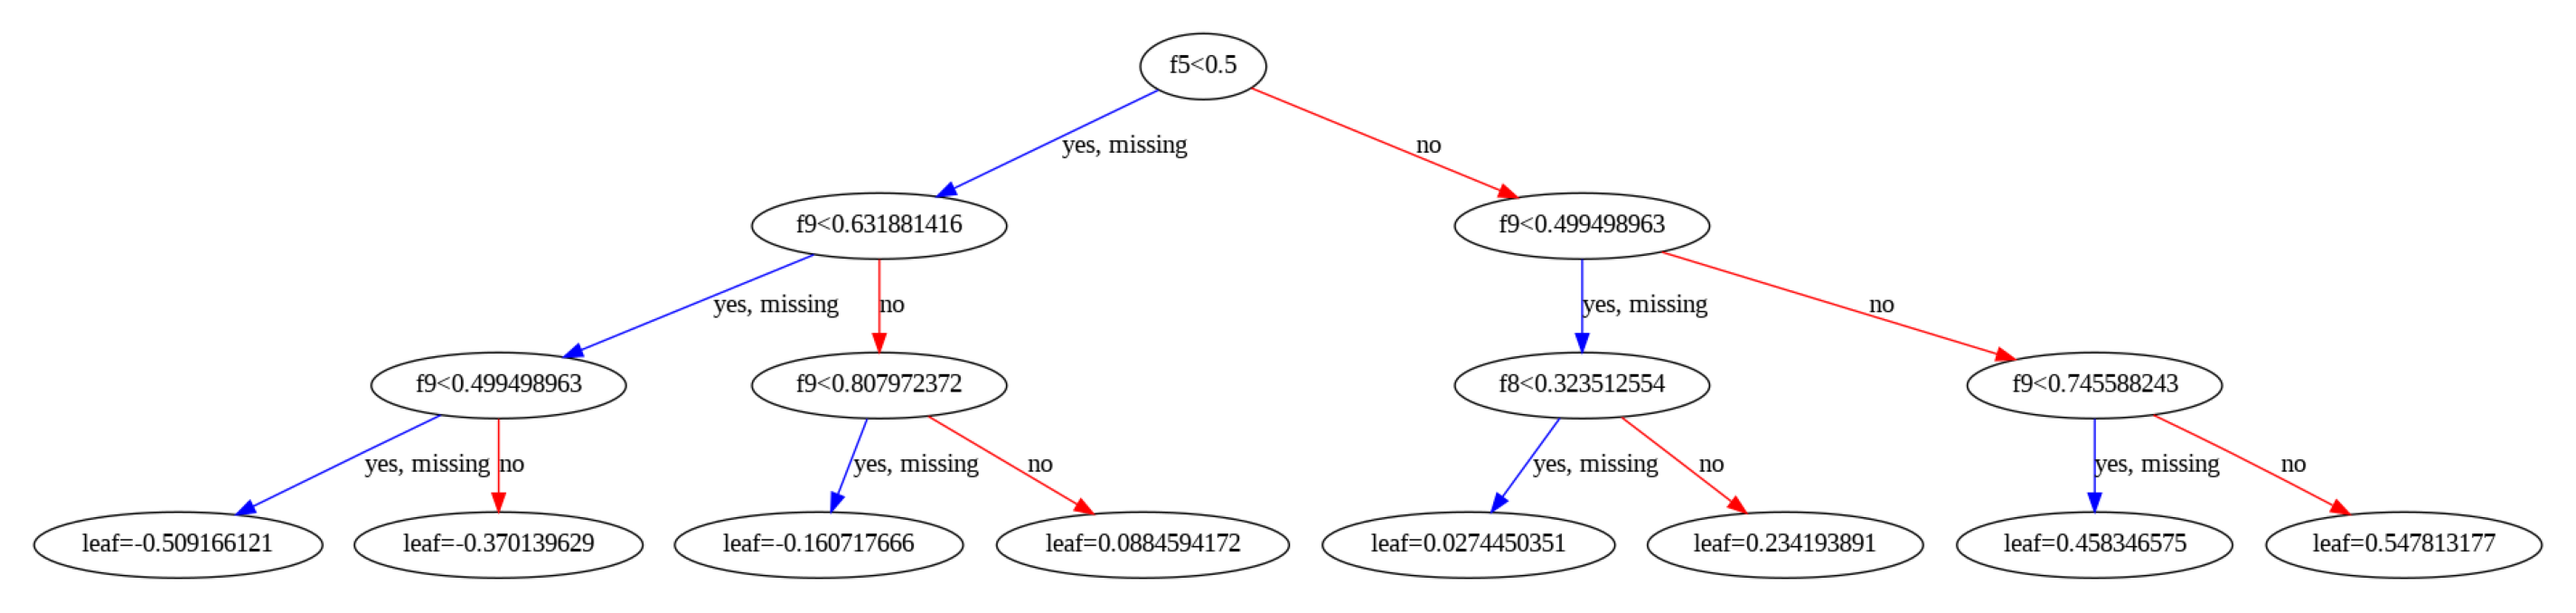

Number of trees: 10
Number of paths on tree: 8
Path 0: [SplitNode(feature='f5', origin='=', gain=19998.9316, count=12223.75, threshold=0.5), SplitNode(feature='f9', origin='<', gain=1903.96484, count=5871.5, threshold=0.631881416), SplitNode(feature='f9', origin='<', gain=124.685547, count=4626.5, threshold=0.499498963), LeafNode(index=7, origin='<', count=3929.25)]


In [ ]:
# Listing 6.16 Extracting XGBoost tree structure

import json
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_tree
from collections import namedtuple

xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=10,
                    max_depth=3) #A

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('xgboost', xgb)]) #B

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["xgboost"]
tree_info = model.get_booster().dump_model("xgb_model.json",
                                           with_stats=True,
                                           dump_format="json") #C

fig, ax = plt.subplots(figsize=(12, 15), dpi=300)
ax = plot_tree(model, num_trees=0, ax=ax) #D
plt.show()

with open("xgb_model.json", "r") as f:
    json_model = json.loads(f.read()) #E

print(f"Number of trees: {len(json_model)}")
tree_structure = json_model[0] #F

Split = namedtuple("SplitNode", "feature origin gain count threshold")
Leaf = namedtuple("LeafNode", "index origin count")

def extract_xgb_node_info(tree):
    return [tree['split'], tree['origin'], tree['gain'],
            tree['cover'], tree['split_condition']] #G

def extract_xgb_leaf_info(tree):
    return [tree['nodeid'], tree['origin'], tree['cover']] #H

def traverse_xgb_tree(tree): #I
    if not 'origin' in tree:
        tree['origin'] = "="
    if not 'children' in tree:
        return [[Leaf(*extract_xgb_leaf_info(tree))]]
    left_branch = tree['children'][0]
    right_branch = tree['children'][1]
    left_branch['origin'] = '<'
    right_branch['origin'] = '>='
    left_paths = traverse_xgb_tree(left_branch)
    right_paths = traverse_xgb_tree(right_branch)
    node_info = [Split(*extract_xgb_node_info(tree))]
    return [node_info + path for path in left_paths + right_paths]

paths = traverse_xgb_tree(tree_structure)

print(f"Number of paths on tree: {len(paths)}")
print("Path 0:", paths[0])

#A creating an XGBoost classifier limited to 10 estimators and trees of 3 levels
#B extracting the XGBoost model from the pipeline
#C dumping the XGBoost model's information (the booster) into a JSON file
#D creating a plot of the first tree in the ensemble
#E retrieving the JSON structure from disk with the model's information
#F printing the number of trees in the model and extract the structure of the first tree
#G function extracting various information from a split node in the tree structure
#H function extracting information from a leaf node in the tree structure
#I function traversing the tree structure recursively to extract paths

[SplitNode(feature=5, origin='', decision_type='<=', threshold=1.0000000180025095e-35, gain=20002.19921875, count=48895), SplitNode(feature=9, origin='yes', decision_type='<=', threshold=0.6330666819550899, gain=1898.2099609375, count=23486), SplitNode(feature=9, origin='yes', decision_type='<=', threshold=0.49949892627057985, gain=204.14199829101562, count=18646), LeafNode(index=0, origin='yes', count=15489, value=-0.17347425948650594)]


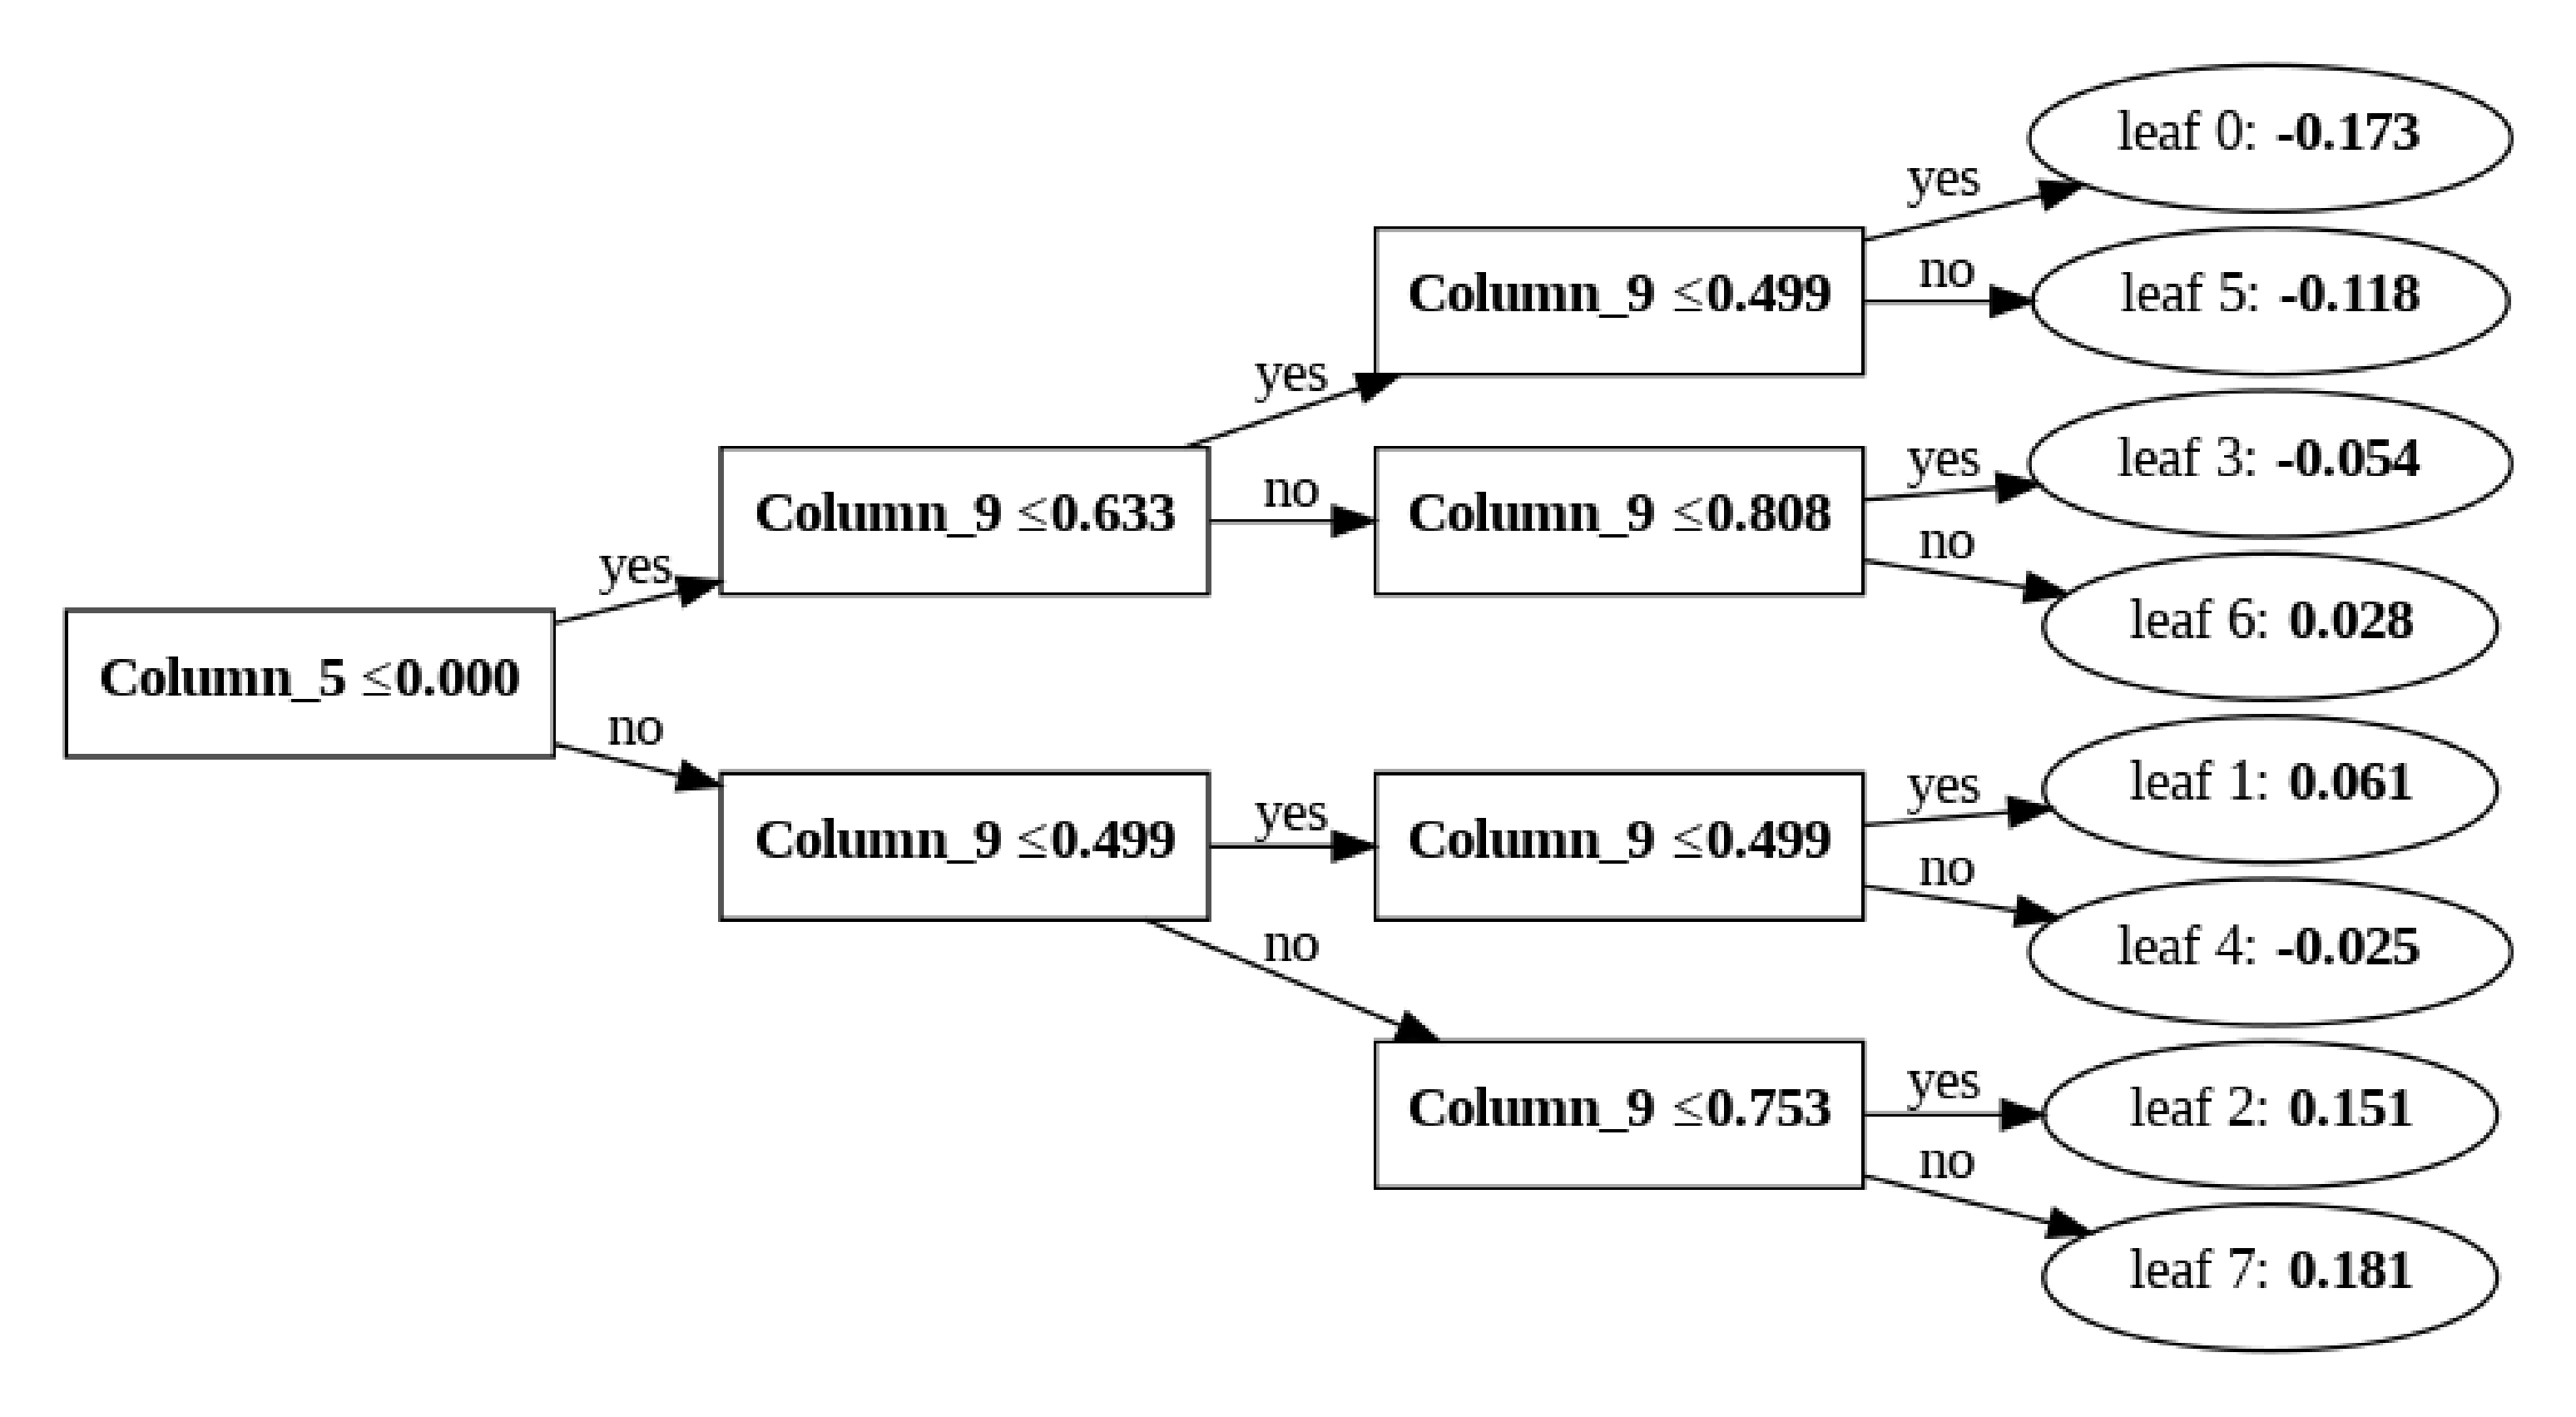

In [ ]:
# Listing 6.17 Extracting LightGBM tree structure

from lightgbm import LGBMClassifier, plot_tree

lgbm = LGBMClassifier(boosting_type='gbdt', 
                      n_estimators=10, 
                      max_depth=3)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('lightgbm', lgbm)])

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["lightgbm"]

tree_info = model._Booster.dump_model()["tree_info"] #A
tree_structure = tree_info[0]['tree_structure'] #B
plot_tree(booster=model._Booster, tree_index=0, dpi=600) #C

Split = namedtuple("SplitNode", "feature origin decision_type threshold gain count")
Leaf = namedtuple("LeafNode", "index origin count value")

def extract_lgbm_node_info(tree): #D
    return [tree['split_feature'], tree['origin'], tree['decision_type'],
            tree['threshold'], tree['split_gain'], tree['internal_count']]

def extract_lgbm_leaf_info(tree): #E
    return [tree['leaf_index'], tree['origin'], tree['leaf_count'], tree['leaf_value']]

def traverse_lgbm_tree(tree): #F
    if not 'origin' in tree:
        tree['origin'] = ""
    if not 'left_child' in tree and not 'right_child' in tree:
        return [[Leaf(*extract_lgbm_leaf_info(tree))]]
    left_branch = tree['left_child']
    right_branch = tree['right_child']
    left_branch['origin'] = 'yes'
    right_branch['origin'] = 'no'
    left_paths = traverse_lgbm_tree(left_branch)
    right_paths = traverse_lgbm_tree(right_branch)
    node_info = [Split(*extract_lgbm_node_info(tree))]
    return [node_info + path for path in left_paths + right_paths]

paths = traverse_lgbm_tree(tree_structure)
print(paths[0])

#A extracting the tree information from the LightGBM model booster
#B extracting the structure of the first tree from the tree information
#C ploting the first tree in the ensemble using the plot_tree function
#D function extracting various information from a split node in the LightGBM tree structure
#E function extracting information from a leaf node in the LightGBM tree structure
#F function recursively traversing the LightGBM tree structure to extract paths

In [ ]:
!pip install tl2cgen treelite treelite_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Listing 6.18 XGBoost prediction speedup by treelite

import treelite
import treelite_runtime
import tl2cgen

xgb = XGBClassifier(booster='gbtree',
                	objective='reg:logistic',
                	n_estimators=10,
                	max_depth=3)

model_pipeline = Pipeline(
	[('processing', column_transform),
 	('xgboost', xgb)])

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["xgboost"]

model.save_model("./xgb_model.json") #A
treelite_model = treelite.Model.load("./xgb_model.json", model_format="xgboost_json") #B
tl2cgen.generate_c_code(treelite_model, dirpath="./", params={"parallel_comp": 4})
tl2cgen.export_lib(treelite_model, toolchain="gcc", libpath="./xgb_model.so",     
                   params={"parallel_comp": 4})

predictor = tl2cgen.Predictor("./xgb_model.so")
X = model_pipeline["processing"].transform(data) #D
dmat = tl2cgen.DMatrix(X) #E
predictor.predict(dmat) 

#A saving the XGBoost model to a JSON file
#B loadingthe XGBoost model in treelite format from the JSON file
#C generating C code from the treelite model and exporting it as a shared library
#D transforming the input data using the preprocessing steps defined in the pipeline
#E creating a treelite DMatrix from the transformed data, compatible with the exported treelite model

In [ ]:
!pip install leaves

In [ ]:
# Listing 6.19 LightGBM prediction speedup by lleaves

import lleaves

lgbm = LGBMClassifier(boosting_type='gbdt',
                      n_estimators=10,
                      max_depth=3)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('lightgbm', lgbm)])

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["lightgbm"]

model.booster_.save_model('lgb_model.txt') #A

llvm_model = lleaves.Model(model_file="lgb_model.txt") #B
llvm_model.compile() #C
X = model_pipeline["processing"].transform(data) #D
llvm_model.predict(X)

#A saving the LightGBM model to a text file
#B loading the LightGBM model using the lleaves library
#C compiling the loaded LightGBM model into LLVM representation
#D transforming the input data using the preprocessing steps defined in the pipeline